In [1]:
from devito import *
from AI4Advection_Diffusion import PDE_Solver
from examples.cfd import  plot_field
import numpy as np
import torch
import matplotlib.pyplot as plt
from filter.filter_generator import upwind, centre_difference

torch.Size([1, 1, 64, 64])


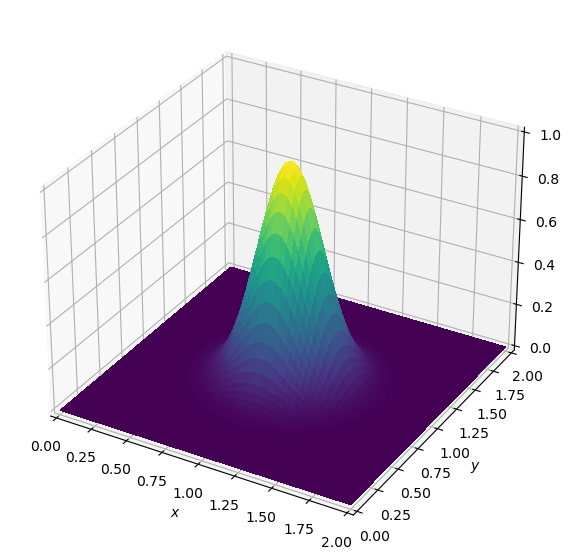

In [2]:

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.001  # Timestep size (sigma=0.2)
nx = 64
ny = 64
length = 2.


# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)
# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor_init_ad = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor_init_ad[0,0,:,:].detach(),f'./advection_equation_result/AD0.pt')
print(u_tensor_init_ad.shape)
plot_field(u.data[0])



In [3]:
D = 0.5
C = 3
eq1 = Eq(u.dt + C*u.dx + D*u.dy)
eq2 = Eq(u.dt, D*u.laplace)

In [4]:
for i in range(1,nt):
    model_adv = PDE_Solver(eq = eq1,u = u, dx = length/nx, dy = length/ny, nx = nx, ny = ny,dt = dt, solver = upwind, omega=1)
    result = model_adv.forward(4)
    u.data[0] = result.detach().numpy()
    model_diff = PDE_Solver(eq = eq2,u = u, dx = length/nx, dy = length/ny, nx = nx, ny = ny,dt = dt, solver = centre_difference, omega=1)
    result = model_diff.forward(4)
    u.data[0] = result.detach().numpy()
    torch.save(result[0,0,:,:].detach(),f'./advection_diffusion_equation_result/AD{i}.pt')

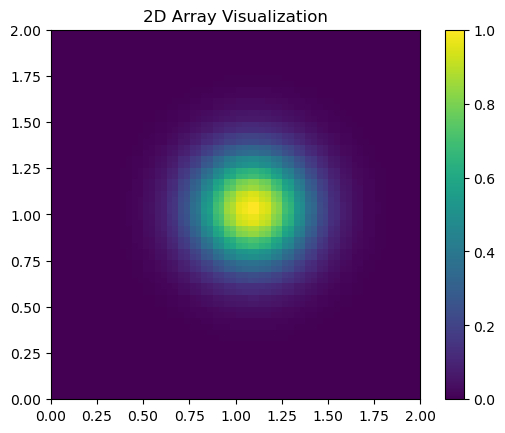

In [5]:
import matplotlib.pyplot as plt
test = torch.load('./advection_diffusion_equation_result/AD4.pt')

plt.imshow(test.numpy(), extent=(0, 2, 0, 2), origin='lower', cmap='viridis')
plt.colorbar()  
plt.title("2D Array Visualization")
plt.show()

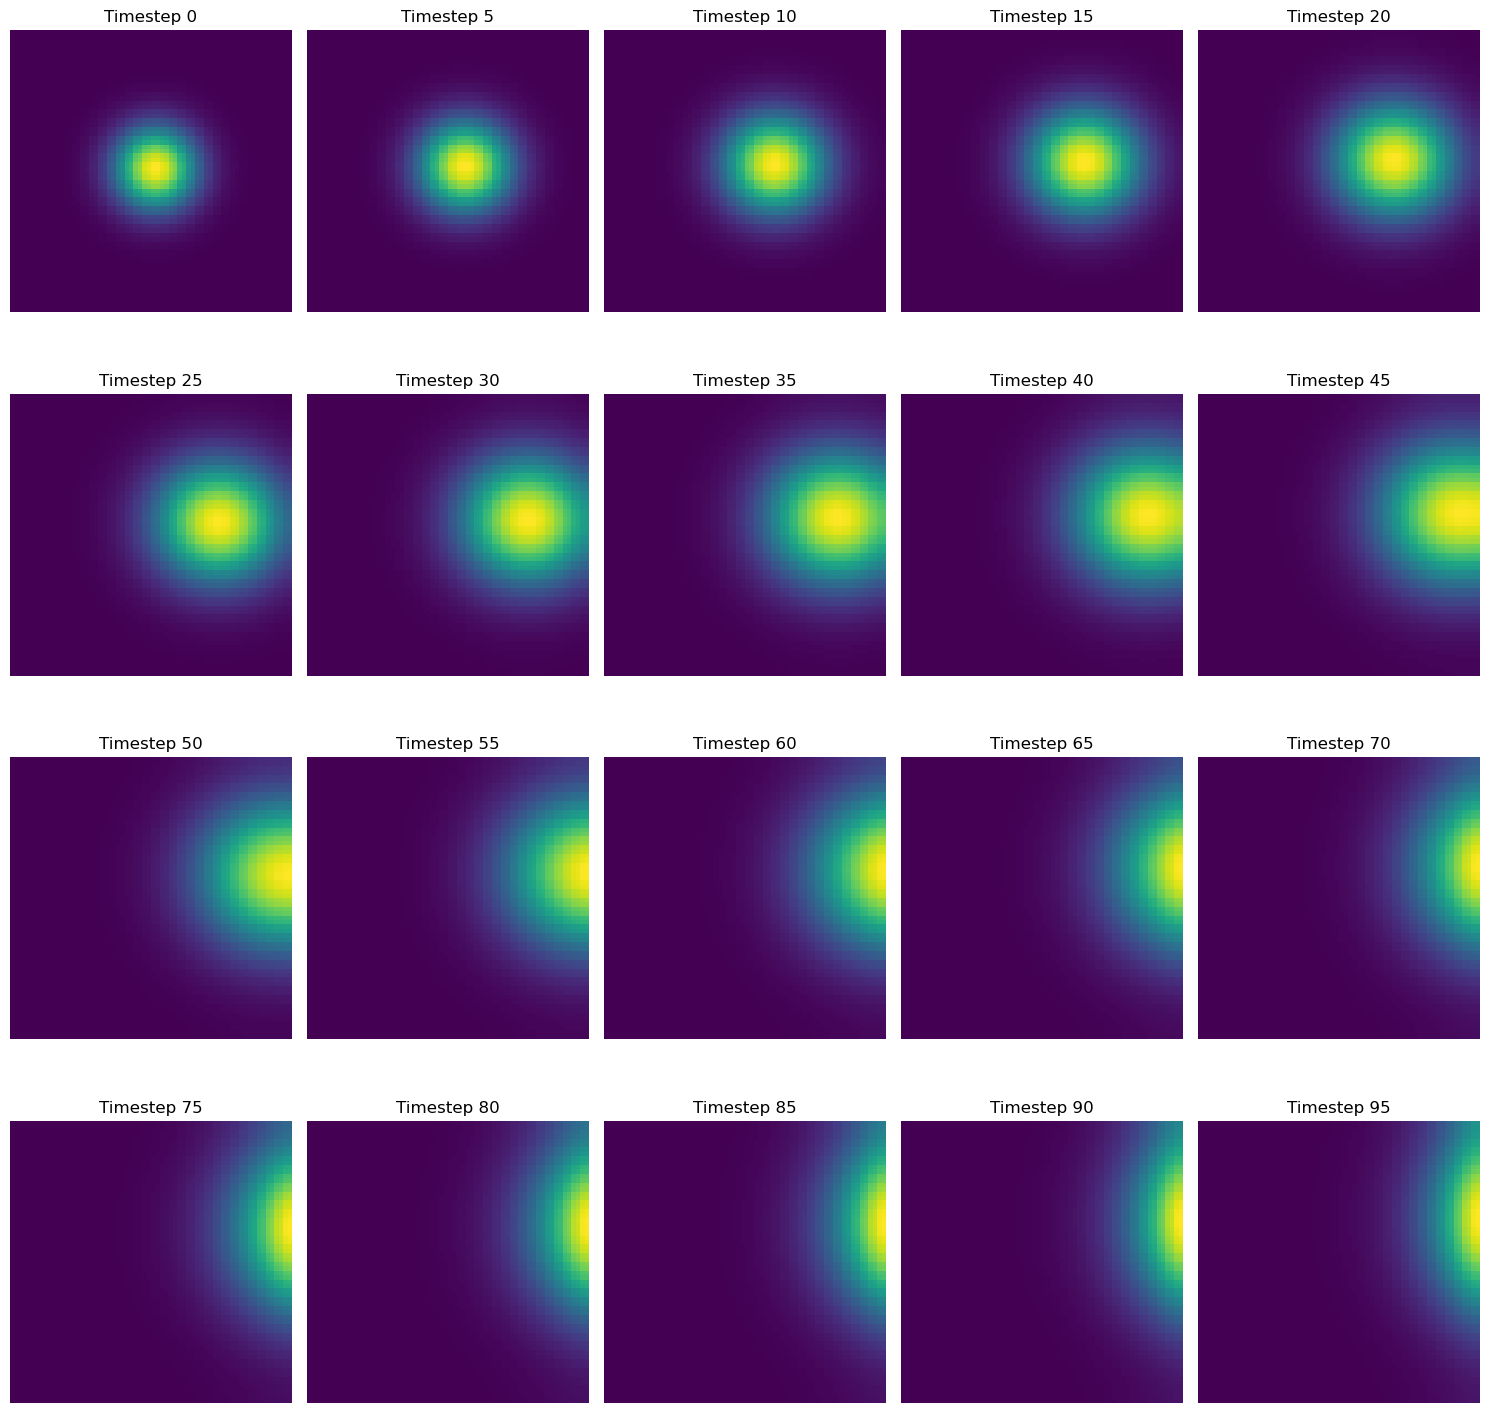

In [8]:
tensors = []
for i in range(1, nt, 5):
    tensor = torch.load(f'./advection_diffusion_equation_result//AD{i}.pt')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor.detach().numpy()
    ax.imshow(data, cmap='viridis', origin='lower',extent=(0,2,0,2))
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()

In [7]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 加载张量数据
tensors = []
for i in range(1, nt):
    tensor = torch.load(f'./advection_equation_result/AD{i}.pt')
    tensors.append(tensor)

# 创建动画
fig, ax = plt.subplots()
def update(frame):
    global cbar
    ax.clear()
    data = tensors[frame].detach().numpy()
    cax = ax.imshow(data, cmap='viridis', origin='lower',extent=(0,2,0,2))
    ax.set_title(f'Timestep {frame}')
    return cax

anim = FuncAnimation(fig, update, frames=len(tensors), interval=200, blit=False)

# 显示动画
plt.close(fig)  # 防止显示静态图
HTML(anim.to_jshtml())